In [1]:
import pandas as pd

df = pd.read_excel("/content/df_top10_ts.xlsx")
df.drop(columns =["Unnamed: 0"],inplace=True)
df

,ProductName,week_year,sum
0,AWC Logo Cap,2021-26,15
1,AWC Logo Cap,2021-27,20
2,AWC Logo Cap,2021-28,19
3,AWC Logo Cap,2021-29,34
4,AWC Logo Cap,2021-30,20
...,...,...,...
524,Water Bottle - 30 oz.,2022-22,164
525,Water Bottle - 30 oz.,2022-23,220
526,Water Bottle - 30 oz.,2022-24,178
527,Water Bottle - 30 oz.,2022-25,195


In [2]:
products = df["ProductName"].unique()
products

array(['AWC Logo Cap', 'Fender Set - Mountain', 'ML Mountain Tire',
       'Mountain Bottle Cage', 'Mountain Tire Tube',
       'Patch Kit/8 Patches', 'Road Bottle Cage', 'Road Tire Tube',
       'Touring Tire Tube', 'Water Bottle - 30 oz.'], dtype=object)

In [3]:
def filter_df(df_temp,product_name):
  df= df_temp.copy()
  df = df[df["ProductName"]==product_name]
  df = df.iloc[:-1]
  return df

temp_df = filter_df(df,'ML Mountain Tire')
print(temp_df)

          ProductName week_year  sum
106  ML Mountain Tire   2021-26    1
107  ML Mountain Tire   2021-27    4
108  ML Mountain Tire   2021-28    2
109  ML Mountain Tire   2021-30   12
110  ML Mountain Tire   2021-31   37
111  ML Mountain Tire   2021-32   44
112  ML Mountain Tire   2021-33   44
113  ML Mountain Tire   2021-34   36
114  ML Mountain Tire   2021-35   56
115  ML Mountain Tire   2021-36   46
116  ML Mountain Tire   2021-37   42
117  ML Mountain Tire   2021-38   33
118  ML Mountain Tire   2021-39   60
119  ML Mountain Tire   2021-40   42
120  ML Mountain Tire   2021-41   46
121  ML Mountain Tire   2021-42   49
122  ML Mountain Tire   2021-43   24
123  ML Mountain Tire   2021-44   46
124  ML Mountain Tire   2021-45   37
125  ML Mountain Tire   2021-46   46
126  ML Mountain Tire   2021-47   46
127  ML Mountain Tire   2021-48   55
128  ML Mountain Tire   2021-49   57
129  ML Mountain Tire   2021-50   49
130  ML Mountain Tire   2021-51   39
131  ML Mountain Tire   2021-52   53
1

Product: AWC Logo Cap
  Best Params: Trend=add, Seasonal=mul, Seasonal Periods=10
  Average MAPE of Best Model: 14.40%



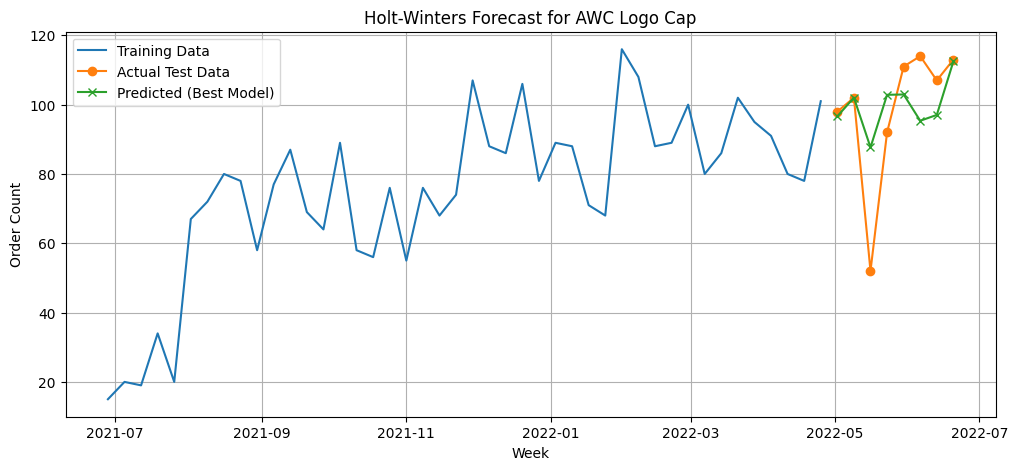

Product: Fender Set - Mountain
  Best Params: Trend=None, Seasonal=add, Seasonal Periods=22
  Average MAPE of Best Model: 13.07%



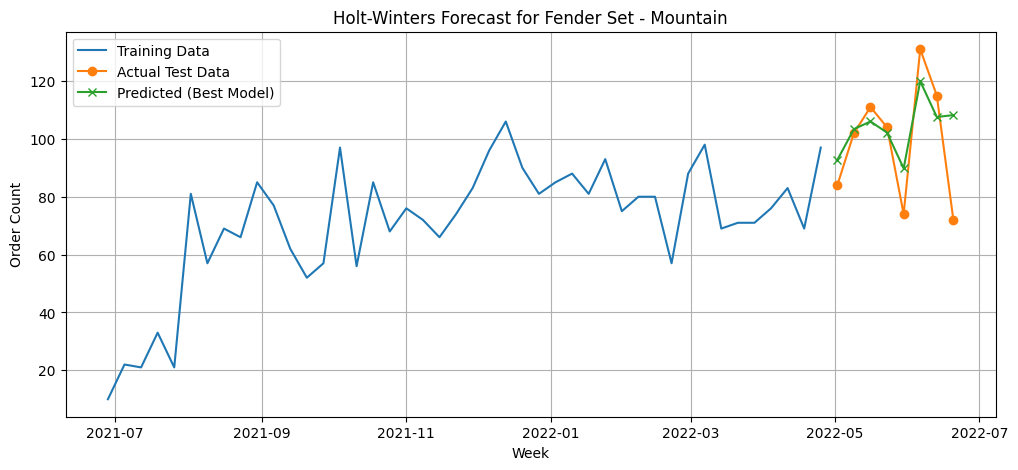

Product: ML Mountain Tire
  Best Params: Trend=mul, Seasonal=add, Seasonal Periods=9
  Average MAPE of Best Model: 16.27%



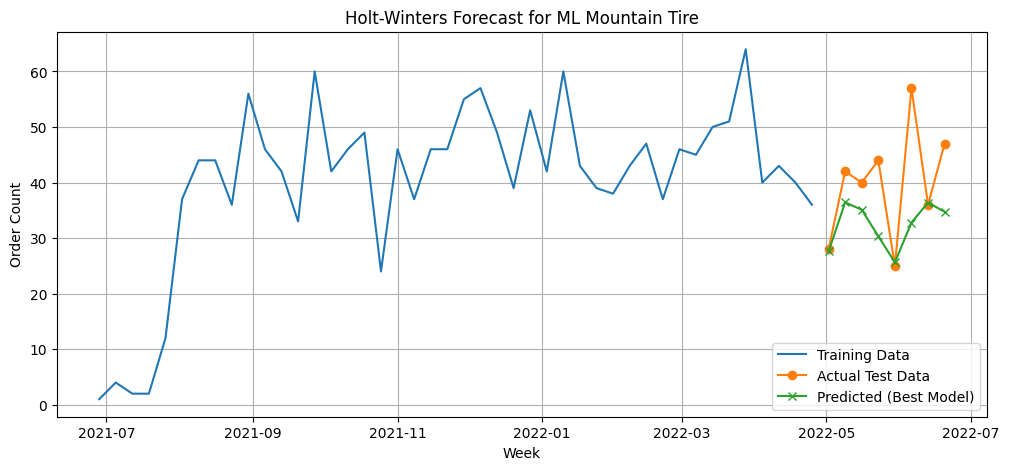

Product: Mountain Bottle Cage
  Best Params: Trend=mul, Seasonal=mul, Seasonal Periods=21
  Average MAPE of Best Model: 8.20%



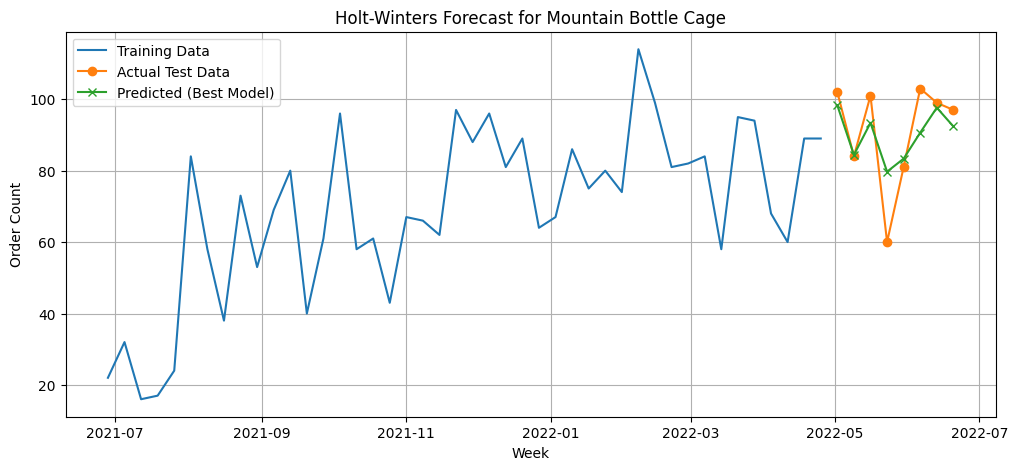

Product: Mountain Tire Tube
  Best Params: Trend=mul, Seasonal=mul, Seasonal Periods=21
  Average MAPE of Best Model: 13.75%



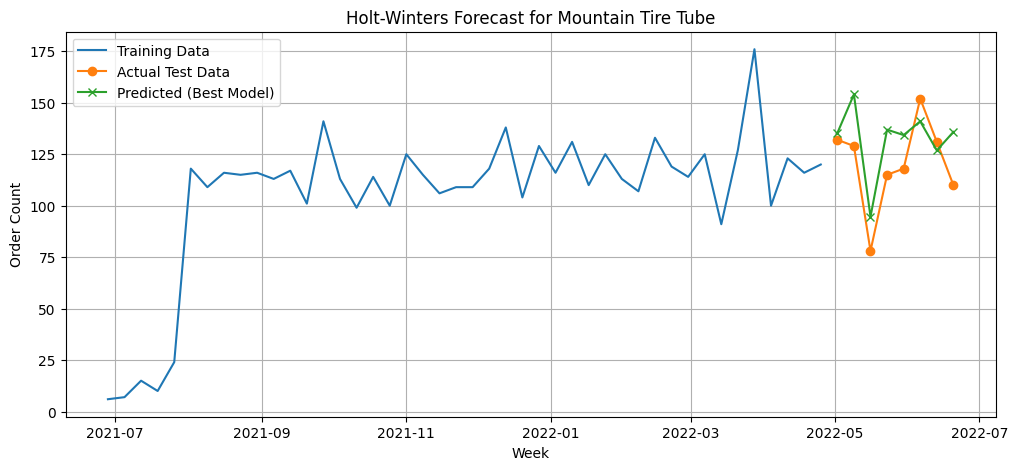

Product: Patch Kit/8 Patches
  Best Params: Trend=None, Seasonal=add, Seasonal Periods=18
  Average MAPE of Best Model: 8.92%



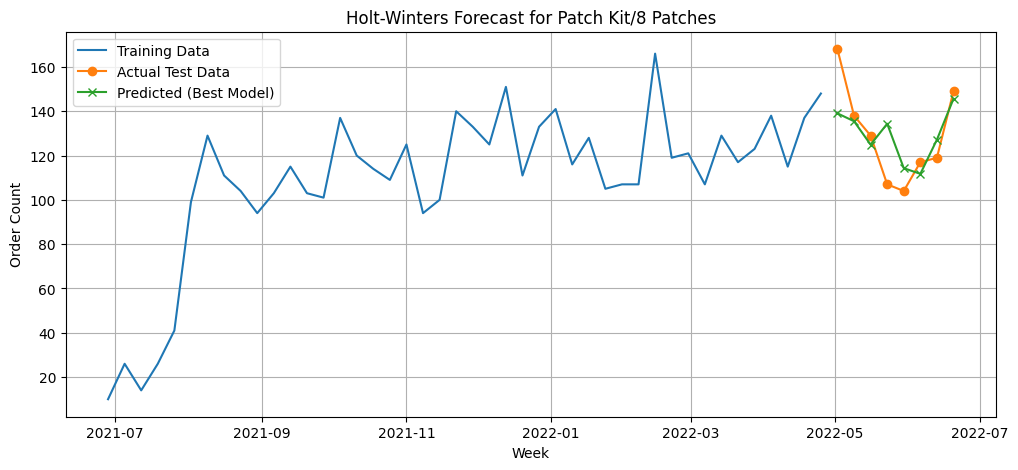

Product: Road Bottle Cage
  Best Params: Trend=None, Seasonal=mul, Seasonal Periods=9
  Average MAPE of Best Model: 10.15%



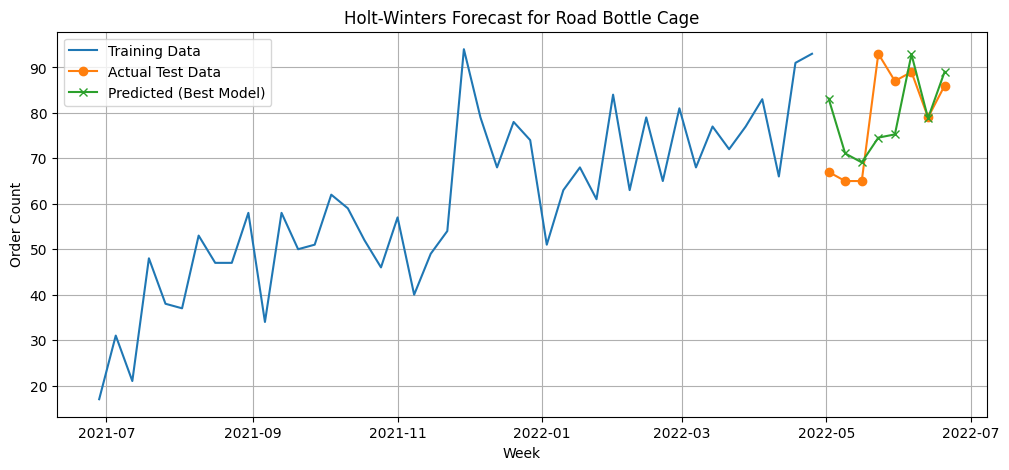

Product: Road Tire Tube
  Best Params: Trend=add, Seasonal=mul, Seasonal Periods=11
  Average MAPE of Best Model: 9.10%



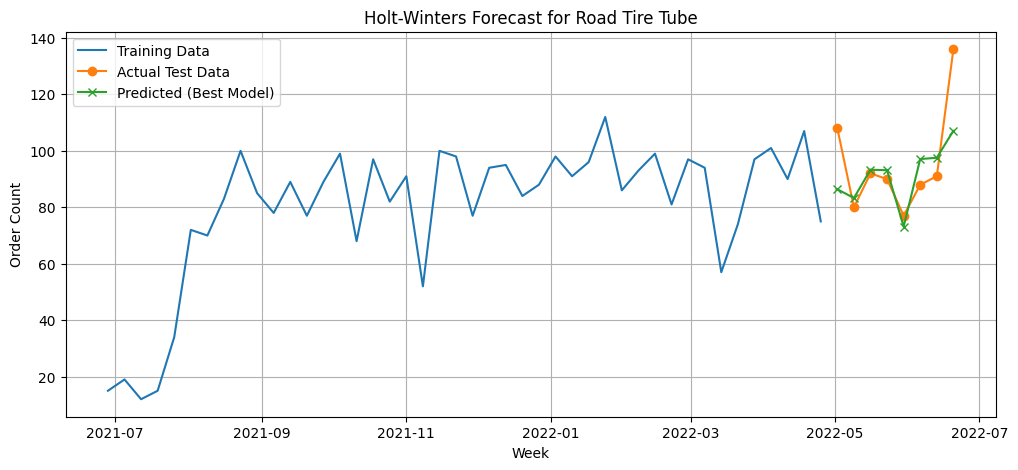

Product: Touring Tire Tube
  Best Params: Trend=None, Seasonal=mul, Seasonal Periods=22
  Average MAPE of Best Model: 10.94%



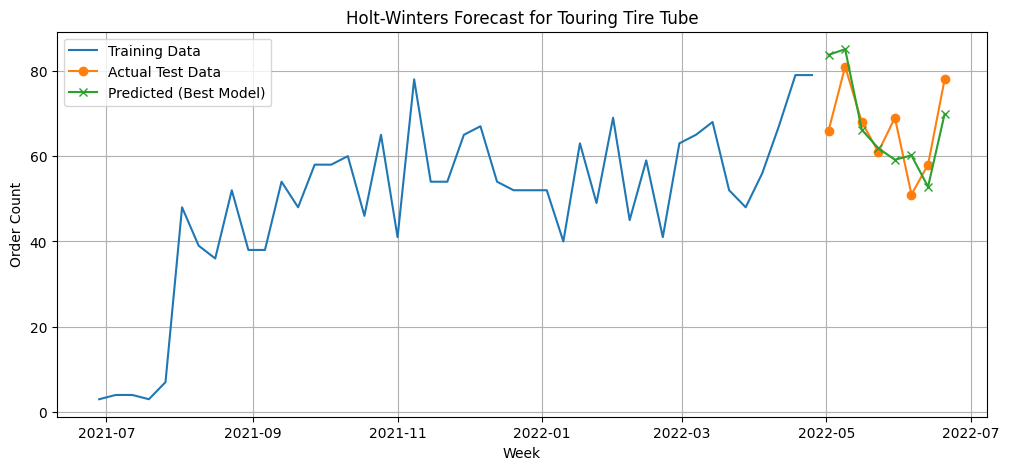

Product: Water Bottle - 30 oz.
  Best Params: Trend=None, Seasonal=mul, Seasonal Periods=7
  Average MAPE of Best Model: 6.66%



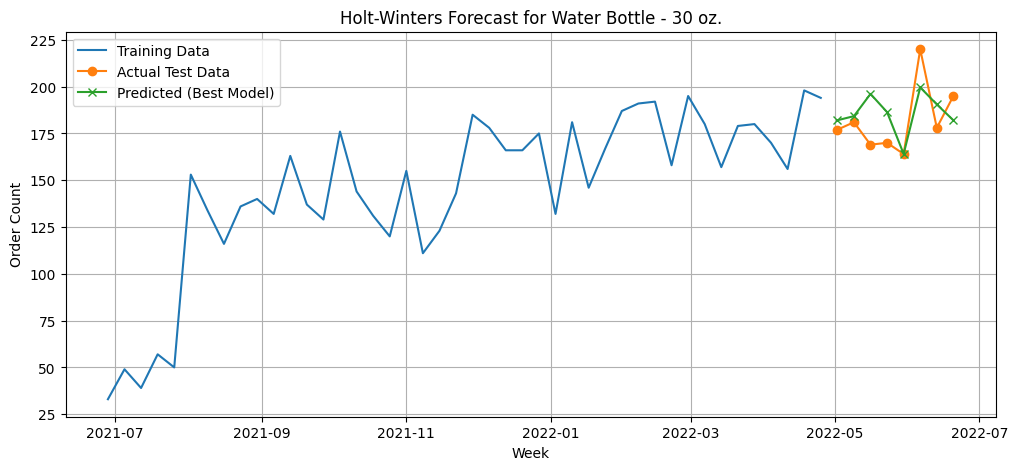


===== SUMMARY OF BEST MODELS =====

                 Product  MAPE (%) Trend Seasonal  Seasonal Period
0           AWC Logo Cap     14.40   add      mul               10
1  Fender Set - Mountain     13.07  None      add               22
2       ML Mountain Tire     16.27   mul      add                9
3   Mountain Bottle Cage      8.20   mul      mul               21
4     Mountain Tire Tube     13.75   mul      mul               21
5    Patch Kit/8 Patches      8.92  None      add               18
6       Road Bottle Cage     10.15  None      mul                9
7         Road Tire Tube      9.10   add      mul               11
8      Touring Tire Tube     10.94  None      mul               22
9  Water Bottle - 30 oz.      6.66  None      mul                7


In [4]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Store summary results here
results = []

for product in products:
    temp_df = filter_df(df, product)

    # Convert "week_year" → datetime
    temp_df['week_year_dt'] = pd.to_datetime(temp_df['week_year'] + '-1', format='%Y-%W-%w')

    # Set datetime index with weekly frequency
    ts = temp_df.set_index('week_year_dt')['sum'].asfreq('W-MON')

    # Fill missing values
    ts = ts.ffill().bfill()

    # Train/test split
    if len(ts) <= 8:
        print(f"Product: {product} -> Not enough data for training/test split.\n")
        continue

    train_series = ts[:-8]
    test_series = ts[-8:]

    # Skip multiplicative if zeros exist
    if (train_series <= 0).any():
        trend_options = ['add', None]
        seasonal_options = ['add', None]
    else:
        trend_options = ['add', 'mul', None]
        seasonal_options = ['add', 'mul', None]

    seasonal_periods_options = list(range(4, min(53, len(train_series)//2 + 1)))

    best_mape = np.inf
    best_params = None
    best_forecast = None

    # Hyperparameter tuning
    for trend in trend_options:
        for seasonal in seasonal_options:
            if trend is None and seasonal is None:
                continue
            for sp in seasonal_periods_options:
                sp_val = sp if seasonal is not None else None
                try:
                    model = ExponentialSmoothing(
                        train_series,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=sp_val
                    ).fit()

                    forecast = model.forecast(8)
                    mape = np.mean(np.abs((test_series - forecast) / test_series)) * 100

                    if mape < best_mape:
                        best_mape = mape
                        best_params = (trend, seasonal, sp_val)
                        best_forecast = forecast
                except:
                    continue

    # Print best results
    print(f"Product: {product}")
    if best_params is not None:
        trend_best, seas_best, sp_best = best_params
        print(f"  Best Params: Trend={trend_best}, Seasonal={seas_best}, Seasonal Periods={sp_best}")
        print(f"  Average MAPE of Best Model: {best_mape:.2f}%\n")

        # Save result to summary table
        results.append({
            "Product": product,
            "MAPE (%)": round(best_mape, 2),
            "Trend": trend_best,
            "Seasonal": seas_best,
            "Seasonal Period": sp_best
        })
    else:
        print("  No valid model could be fit for this product.\n")
        continue  # Skip plotting

    # ======== PLOT TRAIN, TEST, FORECAST ========
    plt.figure(figsize=(12,5))
    plt.plot(train_series.index, train_series, label="Training Data")
    plt.plot(test_series.index, test_series, label="Actual Test Data", marker='o')
    plt.plot(test_series.index, best_forecast, label="Predicted (Best Model)", marker='x')

    plt.title(f"Holt-Winters Forecast for {product}")
    plt.xlabel("Week")
    plt.ylabel("Order Count")
    plt.grid(True)
    plt.legend()
    plt.show()

# ======== SUMMARY DATAFRAME ========
results_df = pd.DataFrame(results)
print("\n===== SUMMARY OF BEST MODELS =====\n")
print(results_df)


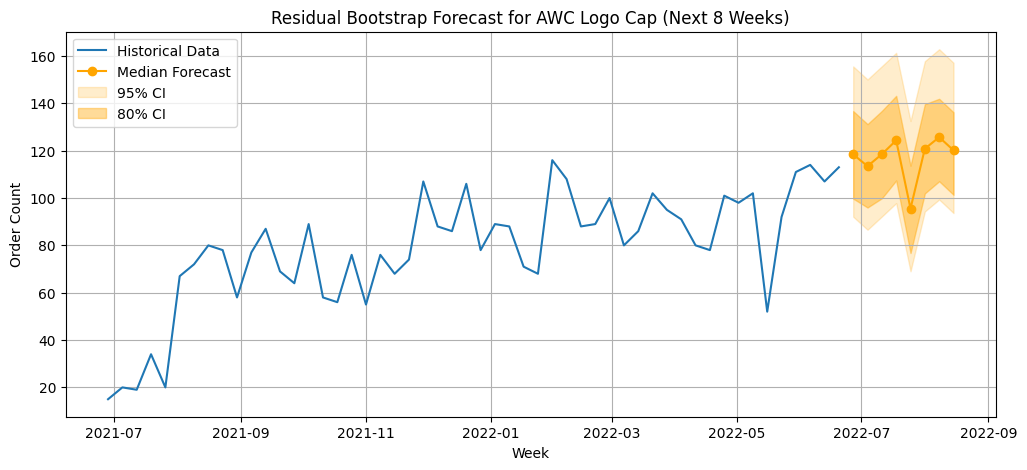

Next 8 week forecast for AWC Logo Cap:

        Week  Median Forecast   Lower 80%   Upper 80%  Lower 95%   Upper 95%
0 2022-06-27       118.435322   99.749993  136.721930  92.114103  155.603161
1 2022-07-04       113.461880   95.994035  131.222759  86.614932  150.103990
2 2022-07-11       118.519624   99.901814  136.806233  92.198406  155.687464
3 2022-07-18       124.361353  107.415233  143.177586  97.850775  161.339833
4 2022-07-25        95.564129   76.764461  113.661379  69.053552  132.542610
5 2022-08-01       120.831125  101.956437  139.647358  94.320548  157.809606
6 2022-08-08       125.702666  107.084855  141.931091  99.381447  162.870505
7 2022-08-15       120.167183  101.367515  136.206249  93.656605  157.145663 



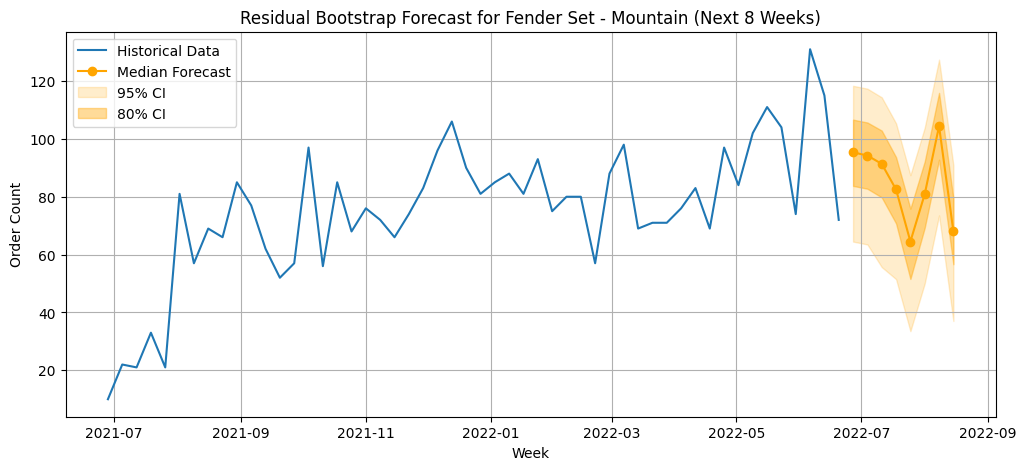

Next 8 week forecast for Fender Set - Mountain:

        Week  Median Forecast  Lower 80%   Upper 80%  Lower 95%   Upper 95%
0 2022-06-27        95.350318  83.758248  106.655352  64.496190  118.351485
1 2022-07-04        94.237779  82.767561  105.664666  63.505504  117.360799
2 2022-07-11        91.366977  79.774907  102.875160  55.681287  114.368145
3 2022-07-18        82.516494  70.781833   93.678937  51.519775  105.375070
4 2022-07-25        64.523516  51.574073   75.889107  33.526797   87.456313
5 2022-08-01        80.889447  69.297377   92.194482  50.035319  103.890615
6 2022-08-08       104.394029  92.801959  115.902212  73.539901  127.395197
7 2022-08-15        68.066029  56.662337   79.408298  37.045988   90.901283 



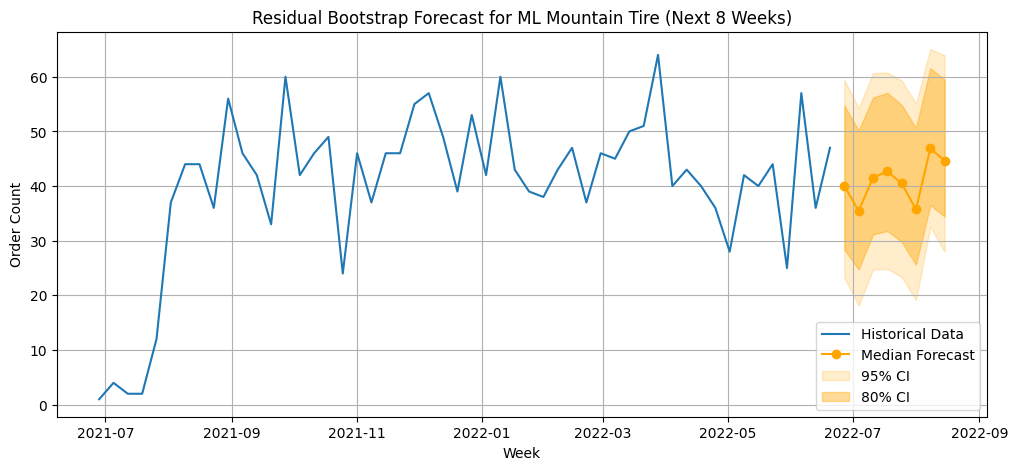

Next 8 week forecast for ML Mountain Tire:

        Week  Median Forecast  Lower 80%  Upper 80%  Lower 95%  Upper 95%
0 2022-06-27        40.068320  28.372323  54.740894  23.251543  59.408758
1 2022-07-04        35.448156  24.758569  50.151256  18.091215  54.259892
2 2022-07-11        41.516886  31.144244  56.189460  24.700109  60.645568
3 2022-07-18        42.675986  31.769627  57.057276  24.843583  60.789042
4 2022-07-25        40.497918  29.808331  54.853546  23.364195  59.309654
5 2022-08-01        35.711057  25.607415  50.652630  19.163279  55.108738
6 2022-08-08        46.887239  36.514598  61.559813  32.537831  65.032630
7 2022-08-15        44.660315  34.422173  59.467389  27.978038  63.923497 



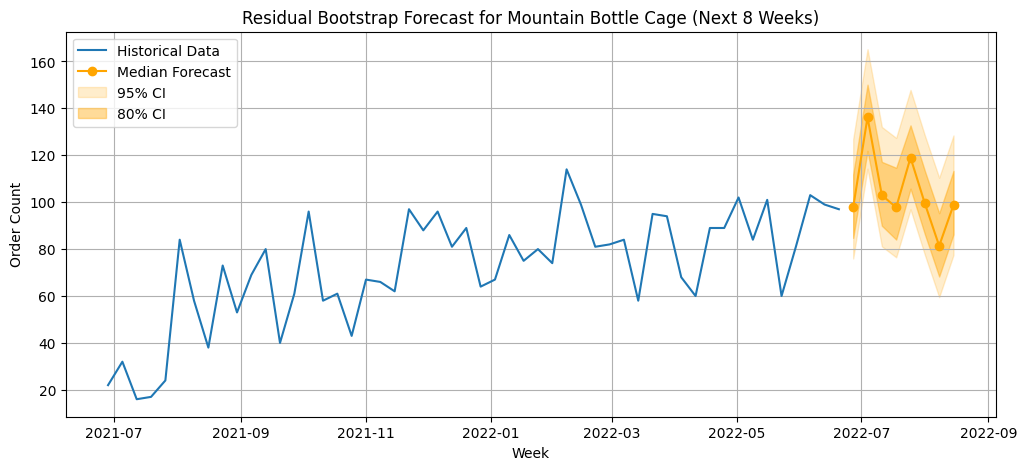

Next 8 week forecast for Mountain Bottle Cage:

        Week  Median Forecast   Lower 80%   Upper 80%   Lower 95%   Upper 95%
0 2022-06-27        97.808477   84.786026  111.776538   75.993095  126.898448
1 2022-07-04       136.180784  121.867354  150.088755  114.305311  165.210664
2 2022-07-11       102.978003   89.955552  117.184112   81.162621  132.067974
3 2022-07-18        97.775755   84.059871  114.661749   76.497828  127.403182
4 2022-07-25       119.016735  105.757747  132.748260   96.964816  147.870170
5 2022-08-01        99.447060   86.364518  113.355030   77.571587  128.476940
6 2022-08-08        81.388185   68.305643   95.296155   59.512711  110.418065
7 2022-08-15        98.814693   86.329698  113.320210   77.536766  128.442120 



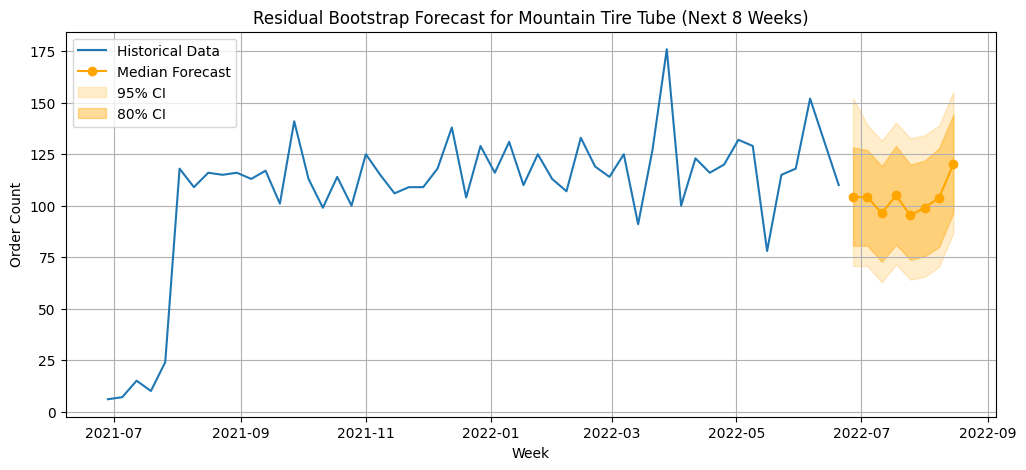

Next 8 week forecast for Mountain Tire Tube:

        Week  Median Forecast  Lower 80%   Upper 80%  Lower 95%   Upper 95%
0 2022-06-27       104.220165  80.620314  128.291333  70.699412  152.063552
1 2022-07-04       104.183021  80.583170  126.989964  70.662269  139.274545
2 2022-07-11        96.374589  72.758388  119.165181  62.837486  131.449762
3 2022-07-18       104.967362  81.068639  129.022180  71.430259  140.361332
4 2022-07-25        95.282109  73.721638  119.941245  64.083258  132.695534
5 2022-08-01        99.046406  75.446555  121.853348  65.525653  134.137929
6 2022-08-08       103.862703  79.963981  127.917522  70.325601  138.937877
7 2022-08-15       120.204657  96.588456  144.259475  86.667554  155.279830 



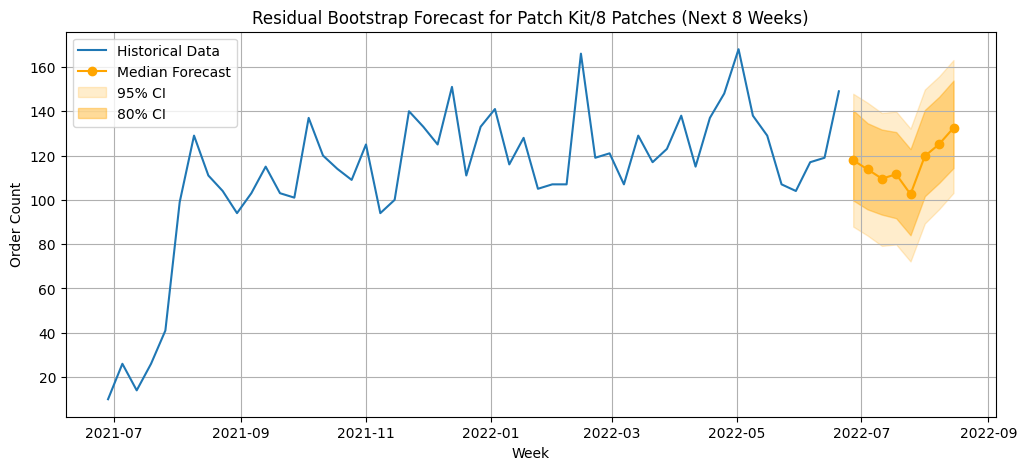

Next 8 week forecast for Patch Kit/8 Patches:

        Week  Median Forecast   Lower 80%   Upper 80%   Lower 95%   Upper 95%
0 2022-06-27       117.836971   99.749086  140.422129   87.917978  147.899709
1 2022-07-04       113.798795   95.710909  134.601191   83.879801  143.861533
2 2022-07-11       109.586898   93.345111  131.731996   79.227845  139.209576
3 2022-07-18       111.542618   91.702268  130.592550   79.871160  139.852891
4 2022-07-25       102.543732   84.015787  122.906069   72.184679  132.166410
5 2022-08-01       119.750457  101.662572  140.552854   89.351866  149.813195
6 2022-08-08       125.164226  107.636692  146.520900   95.805584  155.787316
7 2022-08-15       132.473516  114.374057  153.836265  103.114874  163.096606 



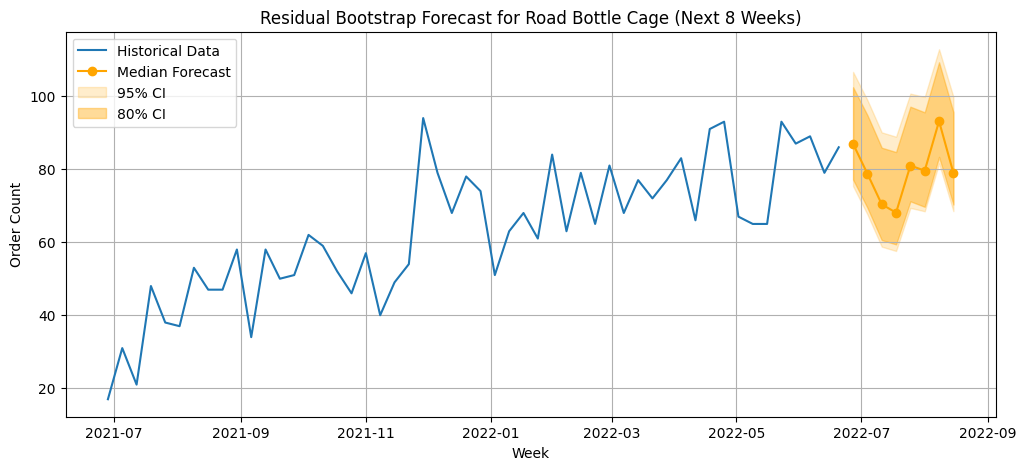

Next 8 week forecast for Road Bottle Cage:

        Week  Median Forecast  Lower 80%   Upper 80%  Lower 95%   Upper 95%
0 2022-06-27        86.939811  77.158108  102.441113  75.347021  106.645872
1 2022-07-04        78.759877  69.452794   94.797971  67.641707   98.940558
2 2022-07-11        70.375385  60.593682   85.876687  58.782596   90.081446
3 2022-07-18        68.089647  59.407042   84.690047  57.595956   88.894806
4 2022-07-25        80.982799  71.201096   97.105826  69.390010  100.688860
5 2022-08-01        79.591153  69.694369   95.567074  68.472983   99.771833
6 2022-08-08        93.143488  83.361785  109.266515  81.550699  112.849549
7 2022-08-15        79.005305  70.322700   95.605705  68.511613   99.810464 



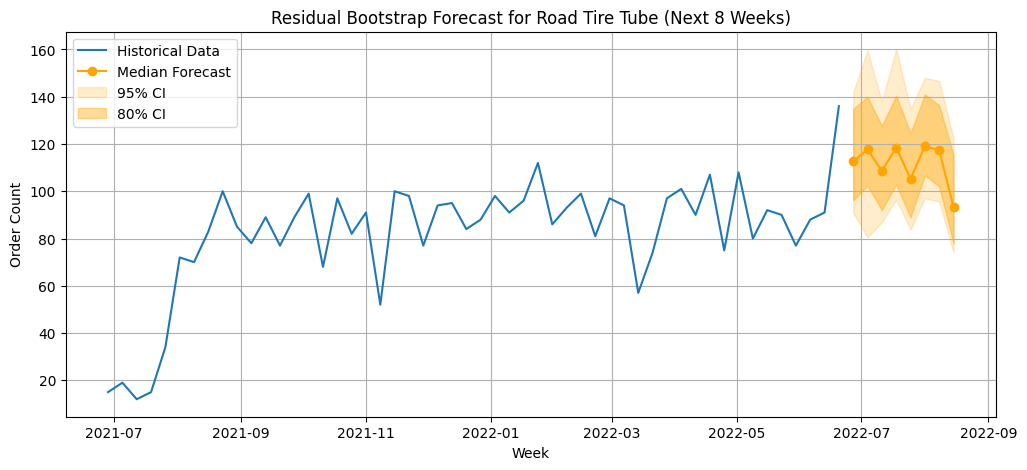

Next 8 week forecast for Road Tire Tube:

        Week  Median Forecast   Lower 80%   Upper 80%  Lower 95%   Upper 95%
0 2022-06-27       112.607134   96.059463  134.859349  90.923656  141.890993
1 2022-07-04       117.722937  102.331279  139.975152  80.543735  159.602819
2 2022-07-11       108.576062   92.028391  127.601168  86.892584  137.859921
3 2022-07-18       118.479342  102.954877  140.470304  96.534611  160.097970
4 2022-07-25       105.293305   88.926659  124.499436  83.790852  134.758189
5 2022-08-01       118.978675  106.778033  140.969637  97.033944  148.001281
6 2022-08-08       117.342566  102.079354  136.367672  95.659088  146.626425
7 2022-08-15        93.391420   77.866955  115.382382  74.019403  122.414026 



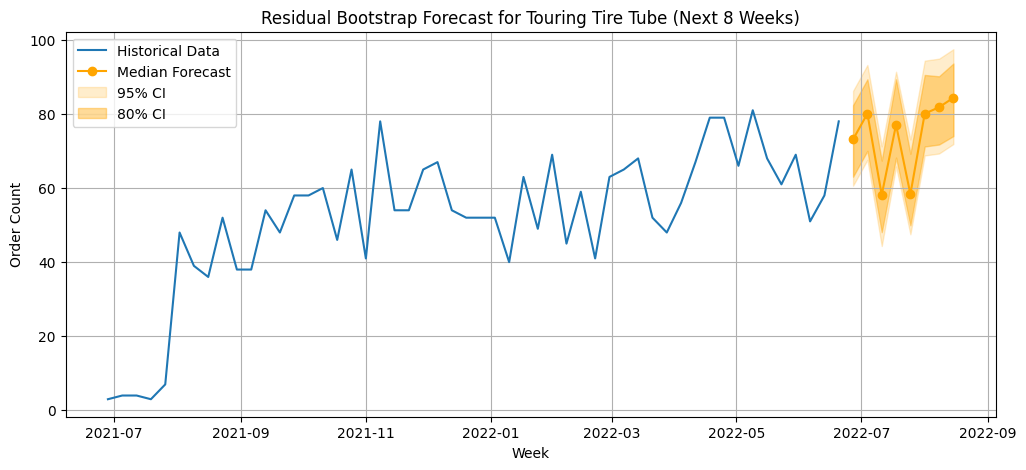

Next 8 week forecast for Touring Tire Tube:

        Week  Median Forecast  Lower 80%  Upper 80%  Lower 95%  Upper 95%
0 2022-06-27        73.128181  63.065048  82.373943  60.636892  86.234498
1 2022-07-04        80.104838  70.041705  89.350600  67.613549  93.211155
2 2022-07-11        58.154229  48.091096  67.399991  44.343331  71.260546
3 2022-07-18        77.084536  68.229785  89.346170  65.801629  91.399235
4 2022-07-25        58.362769  49.940966  69.249861  47.512810  73.110416
5 2022-08-01        80.070245  71.215494  90.524389  68.787338  94.384944
6 2022-08-08        81.815085  71.751952  90.158966  69.323796  94.921402
7 2022-08-15        84.366509  74.024697  93.612271  71.875220  97.472826 



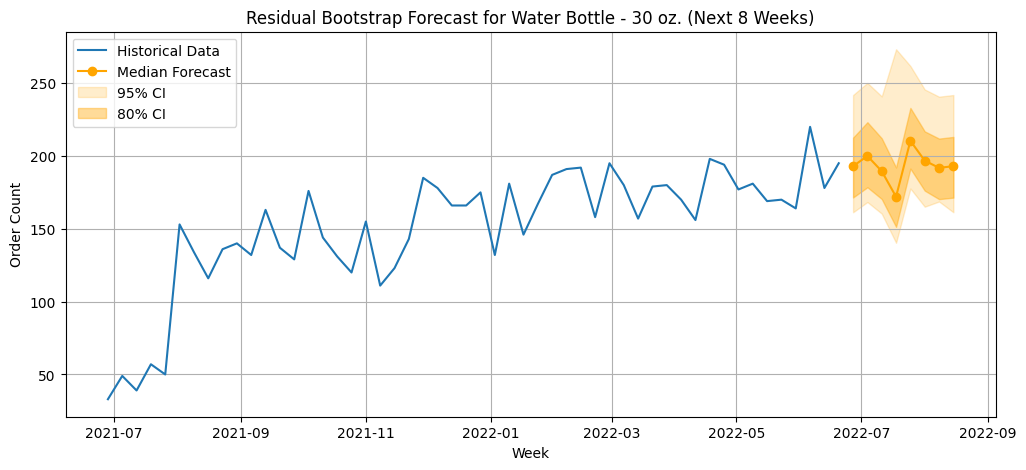

Next 8 week forecast for Water Bottle - 30 oz.:

        Week  Median Forecast   Lower 80%   Upper 80%   Lower 95%   Upper 95%
0 2022-06-27       192.978680  171.507844  212.561169  161.349745  241.834665
1 2022-07-04       199.997956  178.517589  223.173891  168.359490  250.154567
2 2022-07-11       189.542677  170.469888  212.134117  160.419913  240.904833
3 2022-07-18       172.019180  151.337033  192.104449  140.390245  273.281454
4 2022-07-25       210.394985  191.322196  232.986425  177.660813  261.757141
5 2022-08-01       196.799847  176.205331  216.885116  165.170912  245.655831
6 2022-08-08       191.841739  170.370902  211.927007  168.730871  240.697723
7 2022-08-15       192.978680  171.399720  213.063949  161.349745  241.834665 



In [5]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Number of bootstrap simulations
n_simulations = 1000
forecast_horizon = 8  # next 4 weeks

for idx, row in results_df.iterrows():
    product = row['Product']
    trend_best = row['Trend']
    seas_best = row['Seasonal']
    sp_best = row['Seasonal Period']

    temp_df = filter_df(df, product)
    temp_df['week_year_dt'] = pd.to_datetime(temp_df['week_year'] + '-1', format='%Y-%W-%w')
    ts = temp_df.set_index('week_year_dt')['sum'].asfreq('W-MON').ffill().bfill()

    # Fit model on all data
    model_full = ExponentialSmoothing(
        ts,
        trend=trend_best,
        seasonal=seas_best,
        seasonal_periods=sp_best
    ).fit()

    # Forecast on training data to get residuals
    fitted_vals = model_full.fittedvalues
    residuals = ts - fitted_vals

    # Bootstrap residuals for prediction intervals
    sim_forecasts = []
    for _ in range(n_simulations):
        boot_resid = np.random.choice(residuals, size=forecast_horizon, replace=True)
        forecast_sim = model_full.forecast(forecast_horizon) + boot_resid
        sim_forecasts.append(forecast_sim.values)

    sim_forecasts = np.array(sim_forecasts)

    # Compute percentiles for confidence intervals
    lower_95 = np.percentile(sim_forecasts, 2.5, axis=0)
    upper_95 = np.percentile(sim_forecasts, 97.5, axis=0)
    lower_80 = np.percentile(sim_forecasts, 10, axis=0)
    upper_80 = np.percentile(sim_forecasts, 90, axis=0)
    median_forecast = np.median(sim_forecasts, axis=0)

    # Forecast index
    forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(weeks=1), periods=forecast_horizon, freq='W-MON')

    # ======== PLOT ========
    plt.figure(figsize=(12,5))
    plt.plot(ts.index, ts, label="Historical Data")
    plt.plot(forecast_index, median_forecast, label="Median Forecast", color='orange', marker='o')

    plt.fill_between(forecast_index, lower_95, upper_95, color='orange', alpha=0.2, label='95% CI')
    plt.fill_between(forecast_index, lower_80, upper_80, color='orange', alpha=0.4, label='80% CI')

    plt.title(f"Residual Bootstrap Forecast for {product} (Next {forecast_horizon} Weeks)")
    plt.xlabel("Week")
    plt.ylabel("Order Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print median forecast and CIs
    forecast_df = pd.DataFrame({
        "Week": forecast_index,
        "Median Forecast": median_forecast,
        "Lower 80%": lower_80,
        "Upper 80%": upper_80,
        "Lower 95%": lower_95,
        "Upper 95%": upper_95
    })
    print(f"Next {forecast_horizon} week forecast for {product}:\n")
    print(forecast_df, "\n")


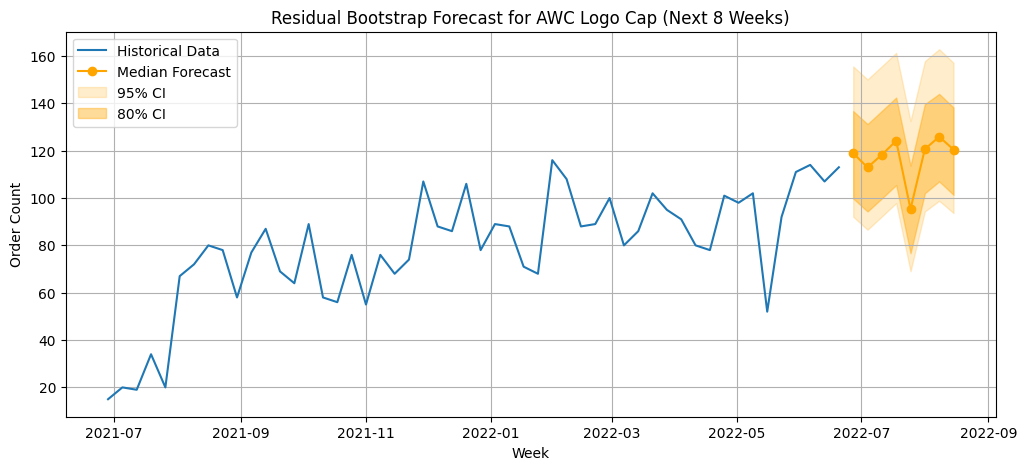

Next 8 week forecast for AWC Logo Cap:

        Product       Week  Median Forecast   Lower 80%   Upper 80%  \
0  AWC Logo Cap 2022-06-27       118.961052   99.825013  136.721930   
1  AWC Logo Cap 2022-07-04       112.936150   94.325841  131.222759   
2  AWC Logo Cap 2022-07-11       118.297385   99.834296  136.806233   
3  AWC Logo Cap 2022-07-18       124.171993  105.486665  142.458602   
4  AWC Logo Cap 2022-07-25        95.374770   76.689441  113.661379   
5  AWC Logo Cap 2022-08-01       120.641766  102.031457  139.647358   
6  AWC Logo Cap 2022-08-08       125.892025  107.017337  143.989274   
7  AWC Logo Cap 2022-08-15       120.503554  101.367515  138.264433   

   Lower 95%   Upper 95%  
0  92.114103  155.603161  
1  86.614932  150.103990  
2  92.198406  155.687464  
3  97.850775  161.339833  
4  69.053552  132.542610  
5  94.320548  157.809606  
6  98.836970  162.870505  
7  93.656605  157.145663   



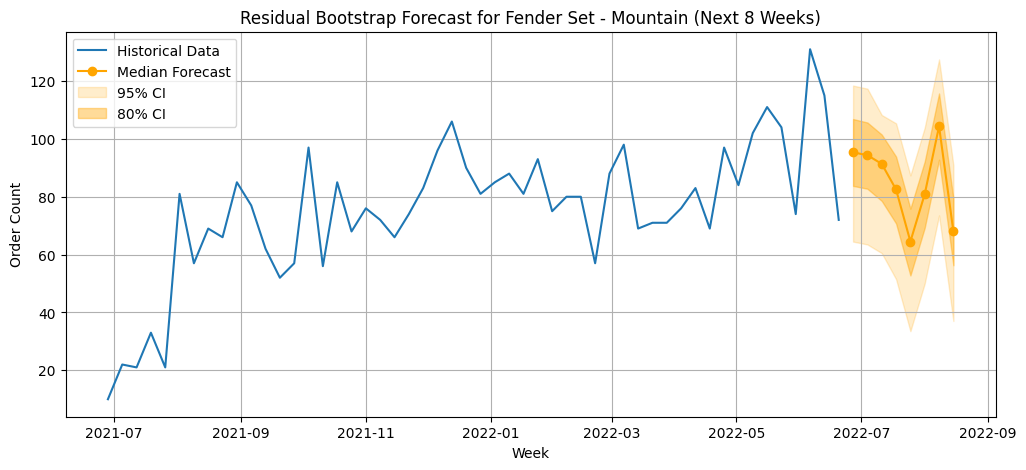

Next 8 week forecast for Fender Set - Mountain:

                 Product       Week  Median Forecast  Lower 80%   Upper 80%  \
0  Fender Set - Mountain 2022-06-27        95.350318  83.758248  106.858501   
1  Fender Set - Mountain 2022-07-04        94.359631  82.767561  105.664666   
2  Fender Set - Mountain 2022-07-11        91.366977  78.560126  101.493894   
3  Fender Set - Mountain 2022-07-18        82.516494  70.781833   93.882086   
4  Fender Set - Mountain 2022-07-25        64.523516  52.788854   75.889107   
5  Fender Set - Mountain 2022-08-01        80.889447  69.297377   92.194482   
6  Fender Set - Mountain 2022-08-08       104.333103  92.801959  115.699064   
7  Fender Set - Mountain 2022-08-15        68.042707  56.308046   79.408298   

   Lower 95%   Upper 95%  
0  64.496190  118.425706  
1  63.505504  117.360799  
2  60.512850  108.260194  
3  51.519775  105.375070  
4  33.526797   87.382092  
5  50.035319  103.890615  
6  73.539901  127.469418  
7  37.045988   90.90128

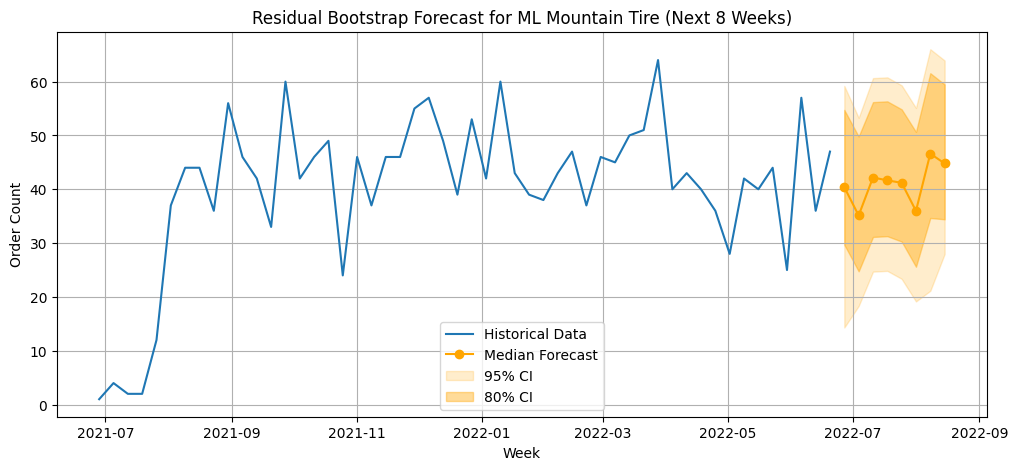

Next 8 week forecast for ML Mountain Tire:

            Product       Week  Median Forecast  Lower 80%  Upper 80%  \
0  ML Mountain Tire 2022-06-27        40.385266  29.695679  54.740894   
1  ML Mountain Tire 2022-07-04        35.131210  24.758569  49.803784   
2  ML Mountain Tire 2022-07-11        42.183172  31.144244  56.189460   
3  ML Mountain Tire 2022-07-18        41.660360  31.287718  56.332934   
4  ML Mountain Tire 2022-07-25        41.196599  30.290240  54.853546   
5  ML Mountain Tire 2022-08-01        35.980056  25.607415  50.652630   
6  ML Mountain Tire 2022-08-08        46.618240  34.664679  61.559813   
7  ML Mountain Tire 2022-08-15        44.794815  34.422173  59.467389   

   Lower 95%  Upper 95%  
0  14.322805  59.197002  
1  18.314433  53.276601  
2  24.700109  60.645568  
3  24.843583  60.789042  
4  23.364195  59.309654  
5  19.163279  55.108738  
6  21.141724  66.015921  
7  27.978038  63.923497   



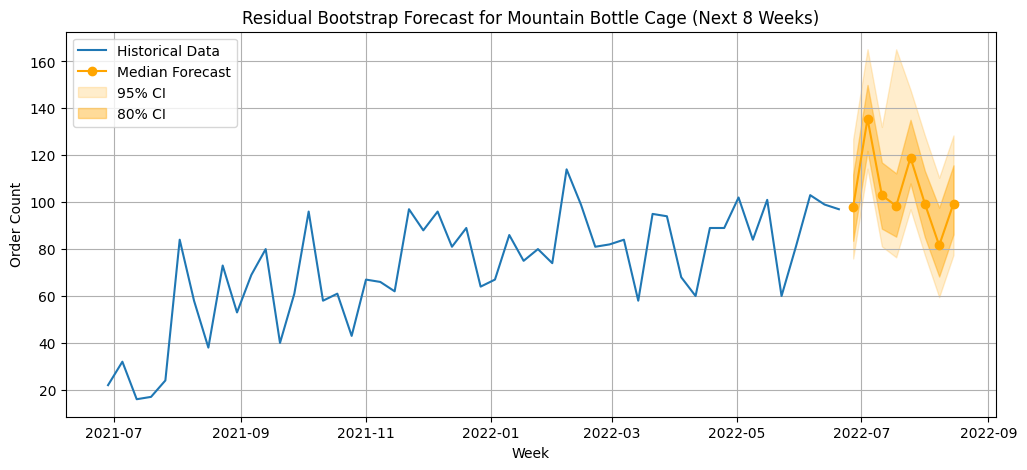

Next 8 week forecast for Mountain Bottle Cage:

                Product       Week  Median Forecast   Lower 80%   Upper 80%  \
0  Mountain Bottle Cage 2022-06-27        98.045013   83.555138  111.776538   
1  Mountain Bottle Cage 2022-07-04       135.583238  121.867354  149.972552   
2  Mountain Bottle Cage 2022-07-11       102.978003   88.724664  116.946065   
3  Mountain Bottle Cage 2022-07-18        98.373302   85.290760  112.281272   
4  Mountain Bottle Cage 2022-07-25       119.016735  107.988487  135.128736   
5  Mountain Bottle Cage 2022-08-01        99.386968   85.133629  113.355030   
6  Mountain Bottle Cage 2022-08-08        81.564630   68.305643   97.676631   
7  Mountain Bottle Cage 2022-08-15        99.412240   86.329698  115.700687   

    Lower 95%   Upper 95%  
0   75.993095  126.898448  
1  114.305311  165.210664  
2   81.162621  132.067974  
3   76.497828  165.173213  
4   96.964816  147.870170  
5   77.489952  128.476940  
6   59.512711  110.418065  
7   77.536766  1

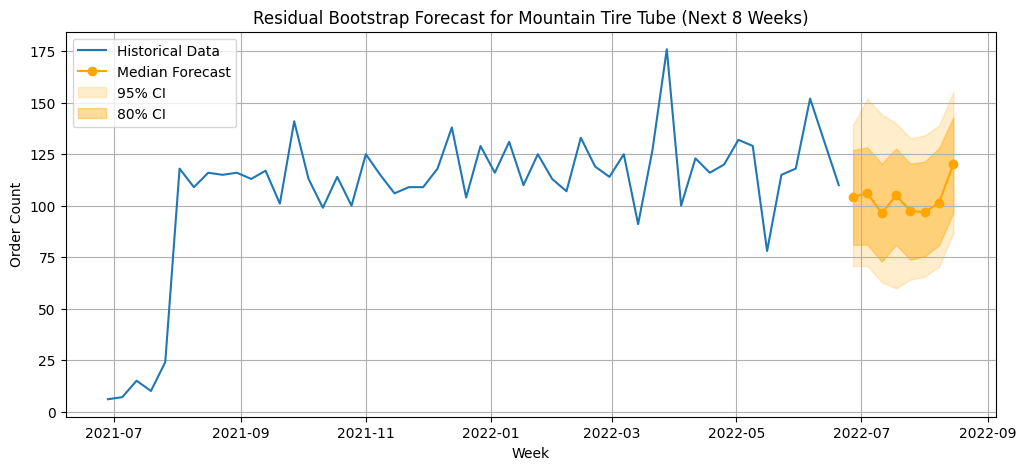

Next 8 week forecast for Mountain Tire Tube:

              Product       Week  Median Forecast  Lower 80%   Upper 80%  \
0  Mountain Tire Tube 2022-06-27       104.236515  81.044946  127.027107   
1  Mountain Tire Tube 2022-07-04       106.044586  81.054984  128.254190   
2  Mountain Tire Tube 2022-07-11        96.358239  72.758388  120.429407   
3  Mountain Tire Tube 2022-07-18       104.951012  81.068639  127.757954   
4  Mountain Tire Tube 2022-07-25        97.604011  73.721638  120.410953   
5  Mountain Tire Tube 2022-08-01        96.724504  75.446555  121.383641   
6  Mountain Tire Tube 2022-08-08       101.524452  80.718316  127.917522   
7  Mountain Tire Tube 2022-08-15       120.188307  96.588456  142.995249   

   Lower 95%   Upper 95%  
0  70.699412  139.311688  
1  70.662269  152.026409  
2  62.837486  144.201626  
3  59.871027  140.042535  
4  64.083258  132.695534  
5  65.525653  134.137929  
6  70.325601  138.937877  
7  86.667554  155.279830   



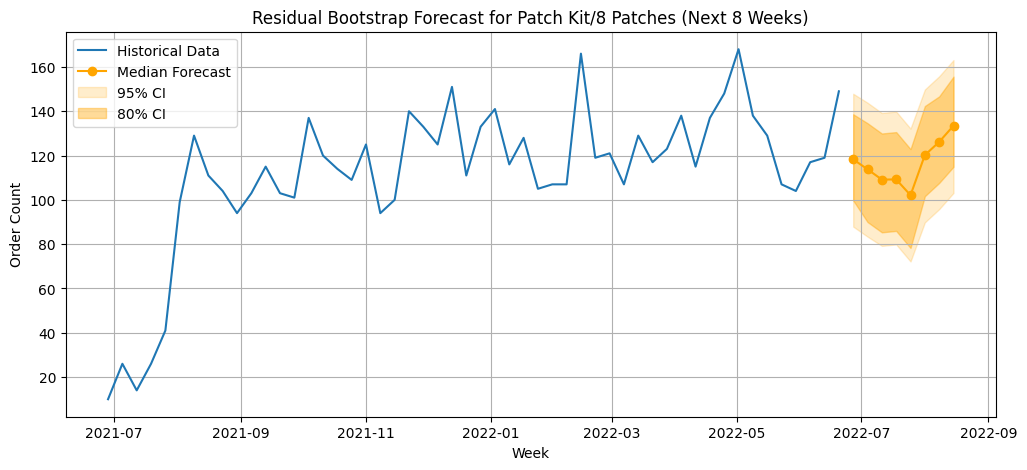

Next 8 week forecast for Patch Kit/8 Patches:

               Product       Week  Median Forecast   Lower 80%   Upper 80%  \
0  Patch Kit/8 Patches 2022-06-27       118.277031   99.749086  138.639368   
1  Patch Kit/8 Patches 2022-07-04       113.798795   89.991652  134.601191   
2  Patch Kit/8 Patches 2022-07-11       109.146838   85.339695  129.949235   
3  Patch Kit/8 Patches 2022-07-18       109.229801   85.983010  130.592550   
4  Patch Kit/8 Patches 2022-07-25       102.103672   78.296529  122.906069   
5  Patch Kit/8 Patches 2022-08-01       120.190517  101.662572  142.335615   
6  Patch Kit/8 Patches 2022-08-08       126.164637  107.636692  146.705250   
7  Patch Kit/8 Patches 2022-08-15       133.473928  114.945983  155.619025   

    Lower 95%   Upper 95%  
0   87.917978  147.899709  
1   83.400204  143.861533  
2   79.227845  139.209576  
3   79.871160  139.852891  
4   72.184679  132.166410  
5   89.831464  149.813195  
6   95.805584  155.787316  
7  103.114874  163.096606 

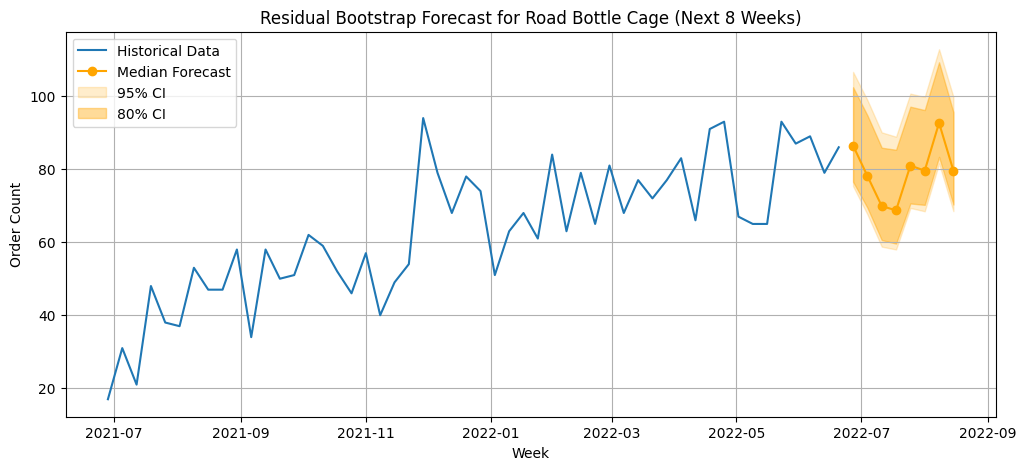

Next 8 week forecast for Road Bottle Cage:

            Product       Week  Median Forecast  Lower 80%   Upper 80%  \
0  Road Bottle Cage 2022-06-27        86.465191  76.568408  102.441113   
1  Road Bottle Cage 2022-07-04        78.135399  69.452794   94.735799   
2  Road Bottle Cage 2022-07-11        69.900766  60.593682   85.876687   
3  Road Bottle Cage 2022-07-18        68.714126  59.617674   85.311771   
4  Road Bottle Cage 2022-07-25        80.982799  70.611396   97.105826   
5  Road Bottle Cage 2022-08-01        79.591153  70.225099   96.188798   
6  Road Bottle Cage 2022-08-08        92.668869  83.361785  109.266515   
7  Road Bottle Cage 2022-08-15        79.629783  70.322700   95.605705   

   Lower 95%   Upper 95%  
0  75.347021  106.645872  
1  67.641707   98.940558  
2  58.782596   90.081446  
3  58.010412   88.894806  
4  69.372768  100.688860  
5  68.472983   99.771833  
6  81.550699  112.849549  
7  68.511613   99.810464   



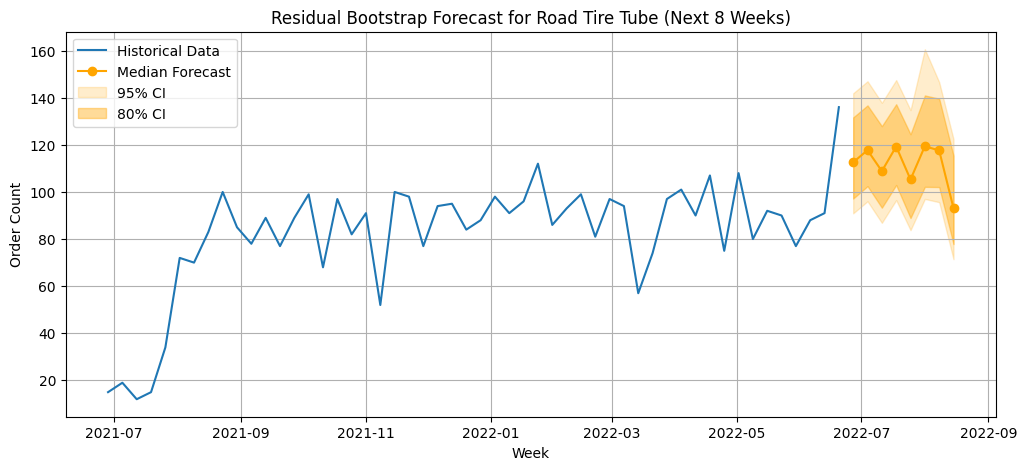

Next 8 week forecast for Road Tire Tube:

          Product       Week  Median Forecast   Lower 80%   Upper 80%  \
0  Road Tire Tube 2022-06-27       112.607134   97.215476  131.632241   
1  Road Tire Tube 2022-07-04       117.722937  102.459725  136.748044   
2  Road Tire Tube 2022-07-11       108.837314   93.312850  127.923879   
3  Road Tire Tube 2022-07-18       119.293253  102.954877  137.243195   
4  Road Tire Tube 2022-07-25       105.293305   88.926659  124.499436   
5  Road Tire Tube 2022-08-01       119.409565  102.169751  140.969637   
6  Road Tire Tube 2022-08-08       117.603819  102.079354  139.594781   
7  Road Tire Tube 2022-08-15        93.130167   77.866955  115.382382   

   Lower 95%   Upper 95%  
0  90.923656  141.890993  
1  96.039459  147.006796  
2  86.892584  137.859921  
3  96.534611  147.501948  
4  83.790852  134.758189  
5  97.033944  160.597303  
6  95.659088  146.626425  
7  71.446689  122.414026   



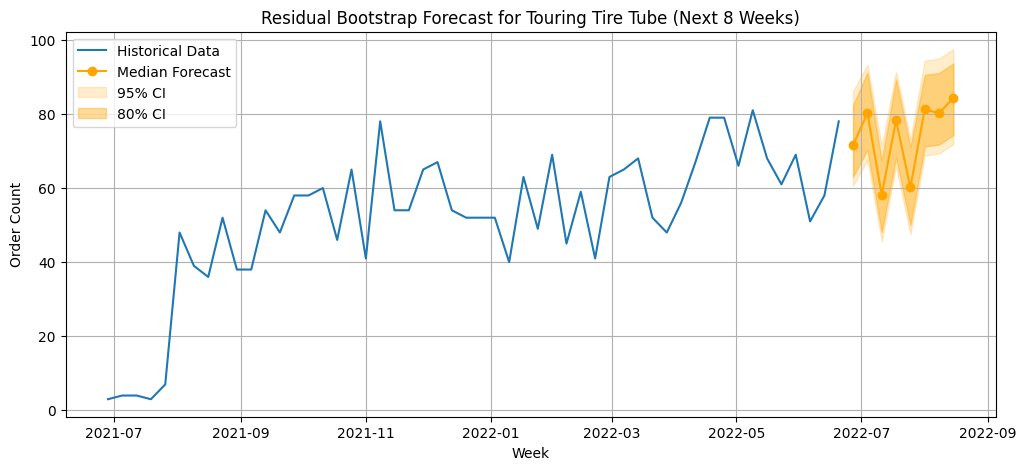

Next 8 week forecast for Touring Tire Tube:

             Product       Week  Median Forecast  Lower 80%  Upper 80%  \
0  Touring Tire Tube 2022-06-27        71.486851  63.065048  82.373943   
1  Touring Tire Tube 2022-07-04        80.258740  70.318027  91.158089   
2  Touring Tire Tube 2022-07-11        58.154229  48.091096  67.399991   
3  Touring Tire Tube 2022-07-18        78.292918  68.229785  89.346170   
4  Touring Tire Tube 2022-07-25        60.158001  49.940966  71.057351   
5  Touring Tire Tube 2022-08-01        81.278627  71.215494  90.524389   
6  Touring Tire Tube 2022-08-08        80.173754  71.751952  91.060847   
7  Touring Tire Tube 2022-08-15        84.366509  74.303376  93.612271   

   Lower 95%  Upper 95%  
0  60.636892  86.234498  
1  67.613549  93.211155  
2  45.662940  71.260546  
3  65.801629  91.399235  
4  47.512810  73.110416  
5  68.787338  94.384944  
6  69.323796  94.921402  
7  71.875220  97.472826   



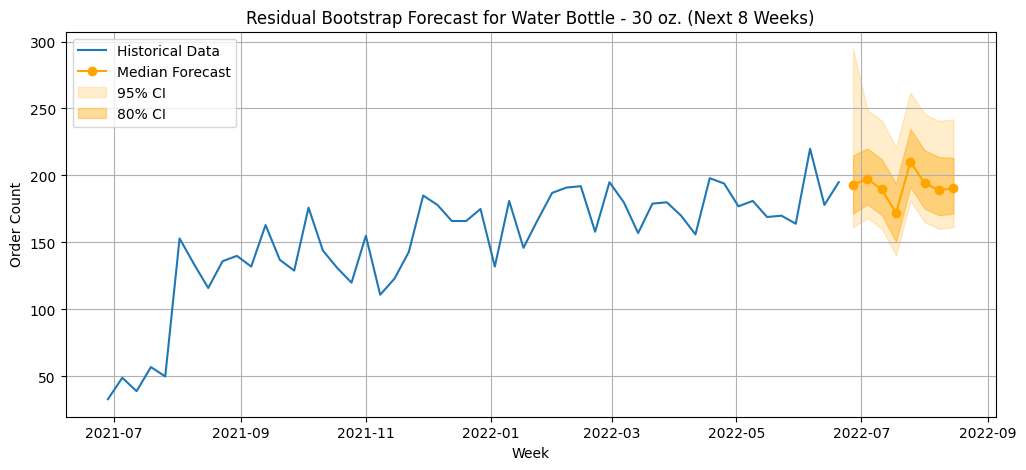

Next 8 week forecast for Water Bottle - 30 oz.:

                 Product       Week  Median Forecast   Lower 80%   Upper 80%  \
0  Water Bottle - 30 oz. 2022-06-27       192.978680  171.507844  214.858484   
1  Water Bottle - 30 oz. 2022-07-04       197.482254  178.517589  220.073694   
2  Water Bottle - 30 oz. 2022-07-11       189.542677  170.578012  212.134117   
3  Water Bottle - 30 oz. 2022-07-18       172.038242  150.548344  193.898984   
4  Water Bottle - 30 oz. 2022-07-25       210.099737  191.322196  234.780960   
5  Water Bottle - 30 oz. 2022-08-01       194.293676  175.220886  218.679650   
6  Water Bottle - 30 oz. 2022-08-08       189.040319  170.370902  213.721542   
7  Water Bottle - 30 oz. 2022-08-15       190.472509  171.507844  213.063949   

    Lower 95%   Upper 95%  
0  161.349745  294.240954  
1  168.359490  248.844410  
2  160.419913  240.904833  
3  140.390245  220.875165  
4  181.272221  261.757141  
5  165.170912  245.655831  
6  160.212803  240.697723  
7  161

In [6]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Number of bootstrap simulations
n_simulations = 1000
forecast_horizon = 8  # next 4 weeks

# NEW: store results here
forecast_results_list = []

for idx, row in results_df.iterrows():
    product = row['Product']
    trend_best = row['Trend']
    seas_best = row['Seasonal']
    sp_best = row['Seasonal Period']

    temp_df = filter_df(df, product)
    temp_df['week_year_dt'] = pd.to_datetime(temp_df['week_year'] + '-1', format='%Y-%W-%w')
    ts = temp_df.set_index('week_year_dt')['sum'].asfreq('W-MON').ffill().bfill()

    # Fit model on all data
    model_full = ExponentialSmoothing(
        ts,
        trend=trend_best,
        seasonal=seas_best,
        seasonal_periods=sp_best
    ).fit()

    # Forecast on training data to get residuals
    fitted_vals = model_full.fittedvalues
    residuals = ts - fitted_vals

    # Bootstrap residuals for prediction intervals
    sim_forecasts = []
    for _ in range(n_simulations):
        boot_resid = np.random.choice(residuals, size=forecast_horizon, replace=True)
        forecast_sim = model_full.forecast(forecast_horizon) + boot_resid
        sim_forecasts.append(forecast_sim.values)

    sim_forecasts = np.array(sim_forecasts)

    # Compute percentiles for confidence intervals
    lower_95 = np.percentile(sim_forecasts, 2.5, axis=0)
    upper_95 = np.percentile(sim_forecasts, 97.5, axis=0)
    lower_80 = np.percentile(sim_forecasts, 10, axis=0)
    upper_80 = np.percentile(sim_forecasts, 90, axis=0)
    median_forecast = np.median(sim_forecasts, axis=0)

    # Forecast index
    forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(weeks=1), periods=forecast_horizon, freq='W-MON')

    # ======== PLOT ========
    plt.figure(figsize=(12,5))
    plt.plot(ts.index, ts, label="Historical Data")
    plt.plot(forecast_index, median_forecast, label="Median Forecast", color='orange', marker='o')

    plt.fill_between(forecast_index, lower_95, upper_95, color='orange', alpha=0.2, label='95% CI')
    plt.fill_between(forecast_index, lower_80, upper_80, color='orange', alpha=0.4, label='80% CI')

    plt.title(f"Residual Bootstrap Forecast for {product} (Next {forecast_horizon} Weeks)")
    plt.xlabel("Week")
    plt.ylabel("Order Count")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Create forecast df
    forecast_df = pd.DataFrame({
        "Product": product,
        "Week": forecast_index,
        "Median Forecast": median_forecast,
        "Lower 80%": lower_80,
        "Upper 80%": upper_80,
        "Lower 95%": lower_95,
        "Upper 95%": upper_95
    })

    # NEW: Append to list
    forecast_results_list.append(forecast_df)

    print(f"Next {forecast_horizon} week forecast for {product}:\n")
    print(forecast_df, "\n")

# NEW: Combine all results into one final dataframe
forecast_results_df = pd.concat(forecast_results_list, ignore_index=True)


In [7]:
forecast_results_df

,Product,Week,Median Forecast,Lower 80%,Upper 80%,Lower 95%,Upper 95%
0,AWC Logo Cap,2022-06-27,118.961052,99.825013,136.721930,92.114103,155.603161
1,AWC Logo Cap,2022-07-04,112.936150,94.325841,131.222759,86.614932,150.103990
2,AWC Logo Cap,2022-07-11,118.297385,99.834296,136.806233,92.198406,155.687464
3,AWC Logo Cap,2022-07-18,124.171993,105.486665,142.458602,97.850775,161.339833
4,AWC Logo Cap,2022-07-25,95.374770,76.689441,113.661379,69.053552,132.542610
...,...,...,...,...,...,...,...
75,Water Bottle - 30 oz.,2022-07-18,172.038242,150.548344,193.898984,140.390245,220.875165
76,Water Bottle - 30 oz.,2022-07-25,210.099737,191.322196,234.780960,181.272221,261.757141
77,Water Bottle - 30 oz.,2022-08-01,194.293676,175.220886,218.679650,165.170912,245.655831
78,Water Bottle - 30 oz.,2022-08-08,189.040319,170.370902,213.721542,160.212803,240.697723


In [8]:
forecast_results_df.to_csv("top10_products_forecast_results.csv",index=False)

In [9]:
df['week_year_dt'] = pd.to_datetime(df['week_year'] + '-1', format='%Y-%W-%w')
df= df.iloc[:-1]
df

,ProductName,week_year,sum,week_year_dt
0,AWC Logo Cap,2021-26,15,2021-06-28
1,AWC Logo Cap,2021-27,20,2021-07-05
2,AWC Logo Cap,2021-28,19,2021-07-12
3,AWC Logo Cap,2021-29,34,2021-07-19
4,AWC Logo Cap,2021-30,20,2021-07-26
...,...,...,...,...
523,Water Bottle - 30 oz.,2022-21,170,2022-05-23
524,Water Bottle - 30 oz.,2022-22,164,2022-05-30
525,Water Bottle - 30 oz.,2022-23,220,2022-06-06
526,Water Bottle - 30 oz.,2022-24,178,2022-06-13


In [10]:
df.to_csv("top10_product_ts.csv",index=False)